In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.linalg import hankel

In [2]:
params = {}
params['embedding_dimension'] = 3

In [3]:
# with open('Results/final_output.pkl', 'rb') as f:
#     results = pickle.load(f)
with open('Results/Model3/final_output.pkl', 'rb') as f:
    results = pickle.load(f)

In [4]:
X_ori = results['x'].cpu().detach().numpy()
z = results['z'].cpu().detach().numpy()
sindy_coeff = results['sindy_coefficients'].cpu().detach().numpy()
Theta = results['Theta'].cpu().detach().numpy()

In [5]:
# Measured_Index (change this based on cases)
measured_index = [0,3,6,9,12,15]
X_ori = X_ori[:, measured_index]

In [6]:
# not measured station (change this based on cases)
no_measure_index = [3]
X_noMeasure = np.load('Data/X_red.npy')[:,no_measure_index].reshape(-1,1)
X_noMeasure_H = hankel(X_noMeasure)
X_noMeasure_H = X_noMeasure_H[:(X_noMeasure.shape[0]-params['embedding_dimension']+1), :params['embedding_dimension']]
train_obs = round(X_noMeasure_H.shape[0]*0.8)
X_noMeasure_H = X_noMeasure_H[train_obs:,:]/100
X_noMeasure = X_noMeasure_H[:,0].reshape(-1,1)

In [7]:
#Combine measured station with not measured station
X_ori = np.concatenate((X_ori, X_noMeasure), axis=1)

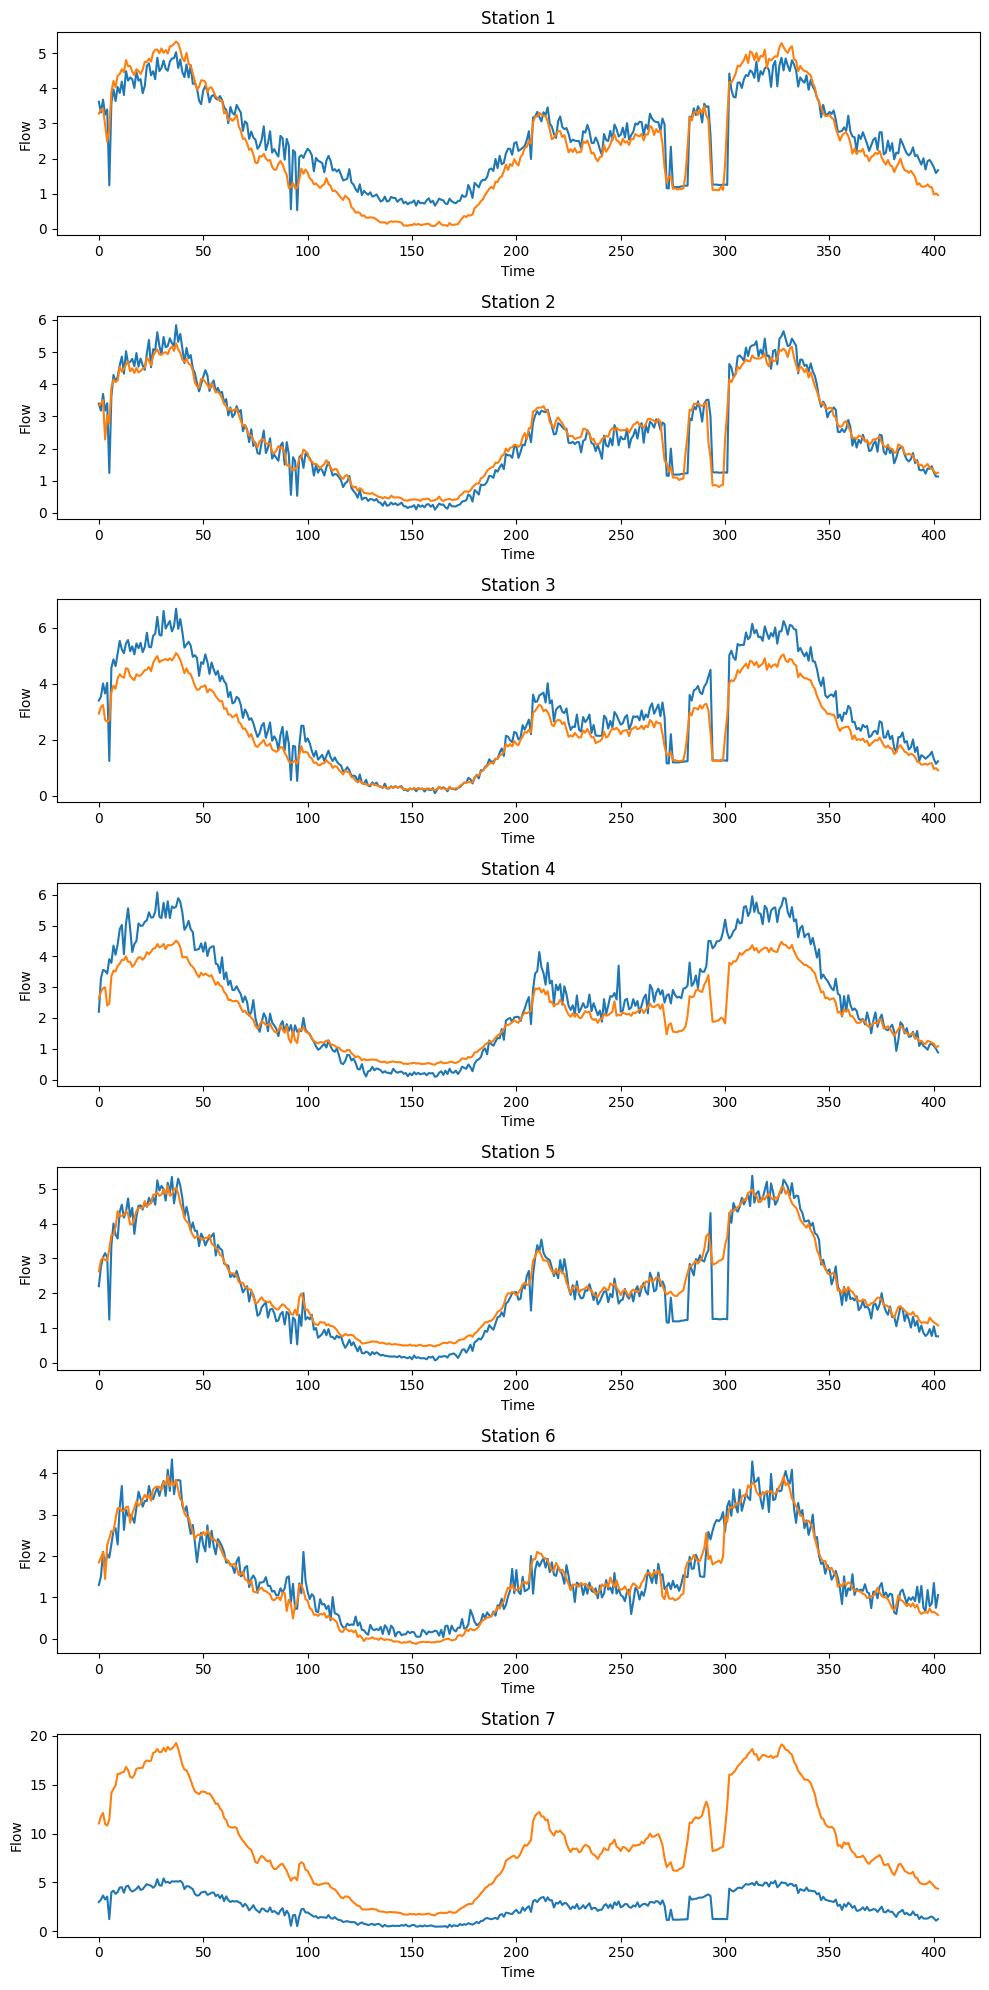

In [8]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(10, 20))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(X_ori[:, i])
    axs[i].plot(z[:,i])

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

In [9]:
dz_predict = results['dz_predict'].cpu().detach().numpy()
dz = results['dz'].cpu().detach().numpy()

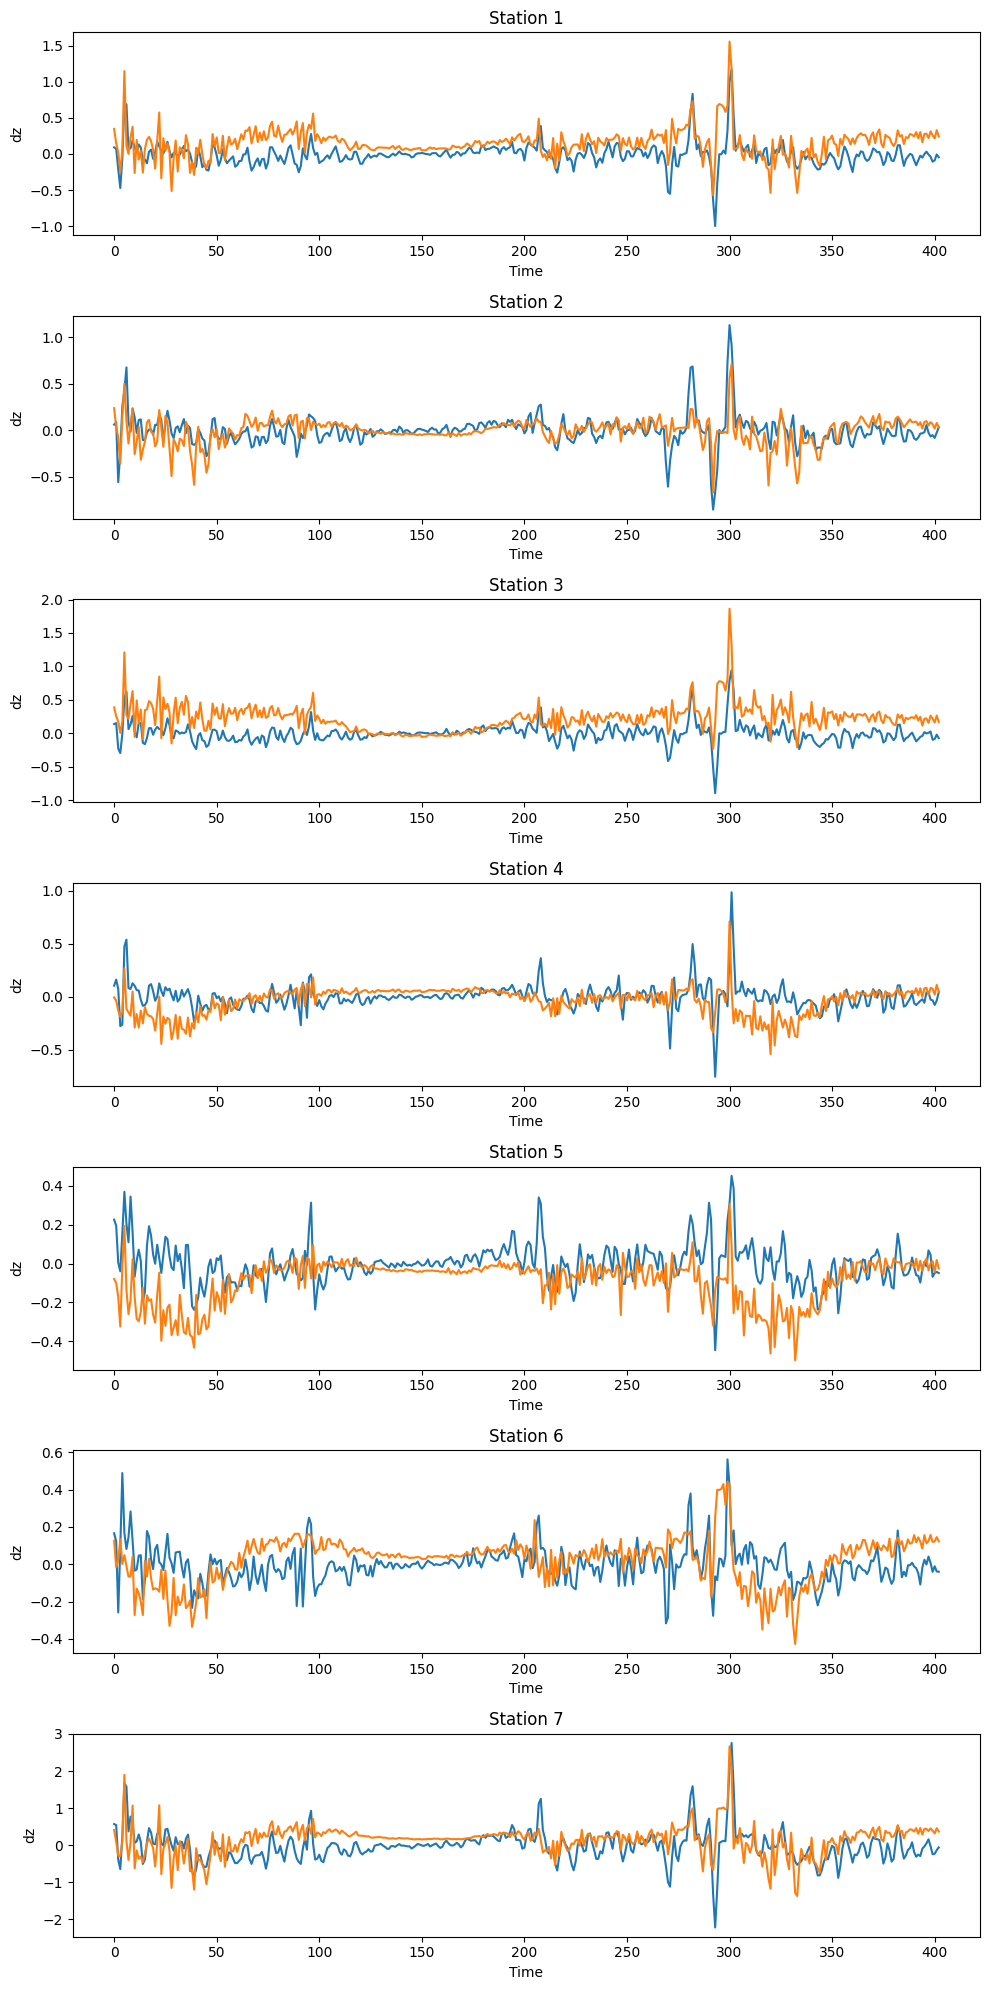

In [10]:
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(10, 20))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(dz[:, i])
    axs[i].plot(dz_predict[:,i])

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('dz')

# Show the figure
plt.tight_layout()
plt.show()

In [51]:
#Simulate data with discovered governing equations
total_sim_timestep = 405
total_pred_step = 3
s = (total_sim_timestep, 7)
sim_result = np.zeros(s)

In [52]:
from sindy_utils import sindy_library

In [53]:
for t in range(0,total_sim_timestep,total_pred_step):
    z_init = z[t,:].reshape(1,-1)
    for s in range(total_pred_step):
        Theta_curr = sindy_library(z_init,2,False)
        dz_curr = np.matmul(Theta_curr,sindy_coeff)
        z_new = z_init + dz_curr
        sim_result[t+s,:] = z_init
        z_init = np.array(z_new)

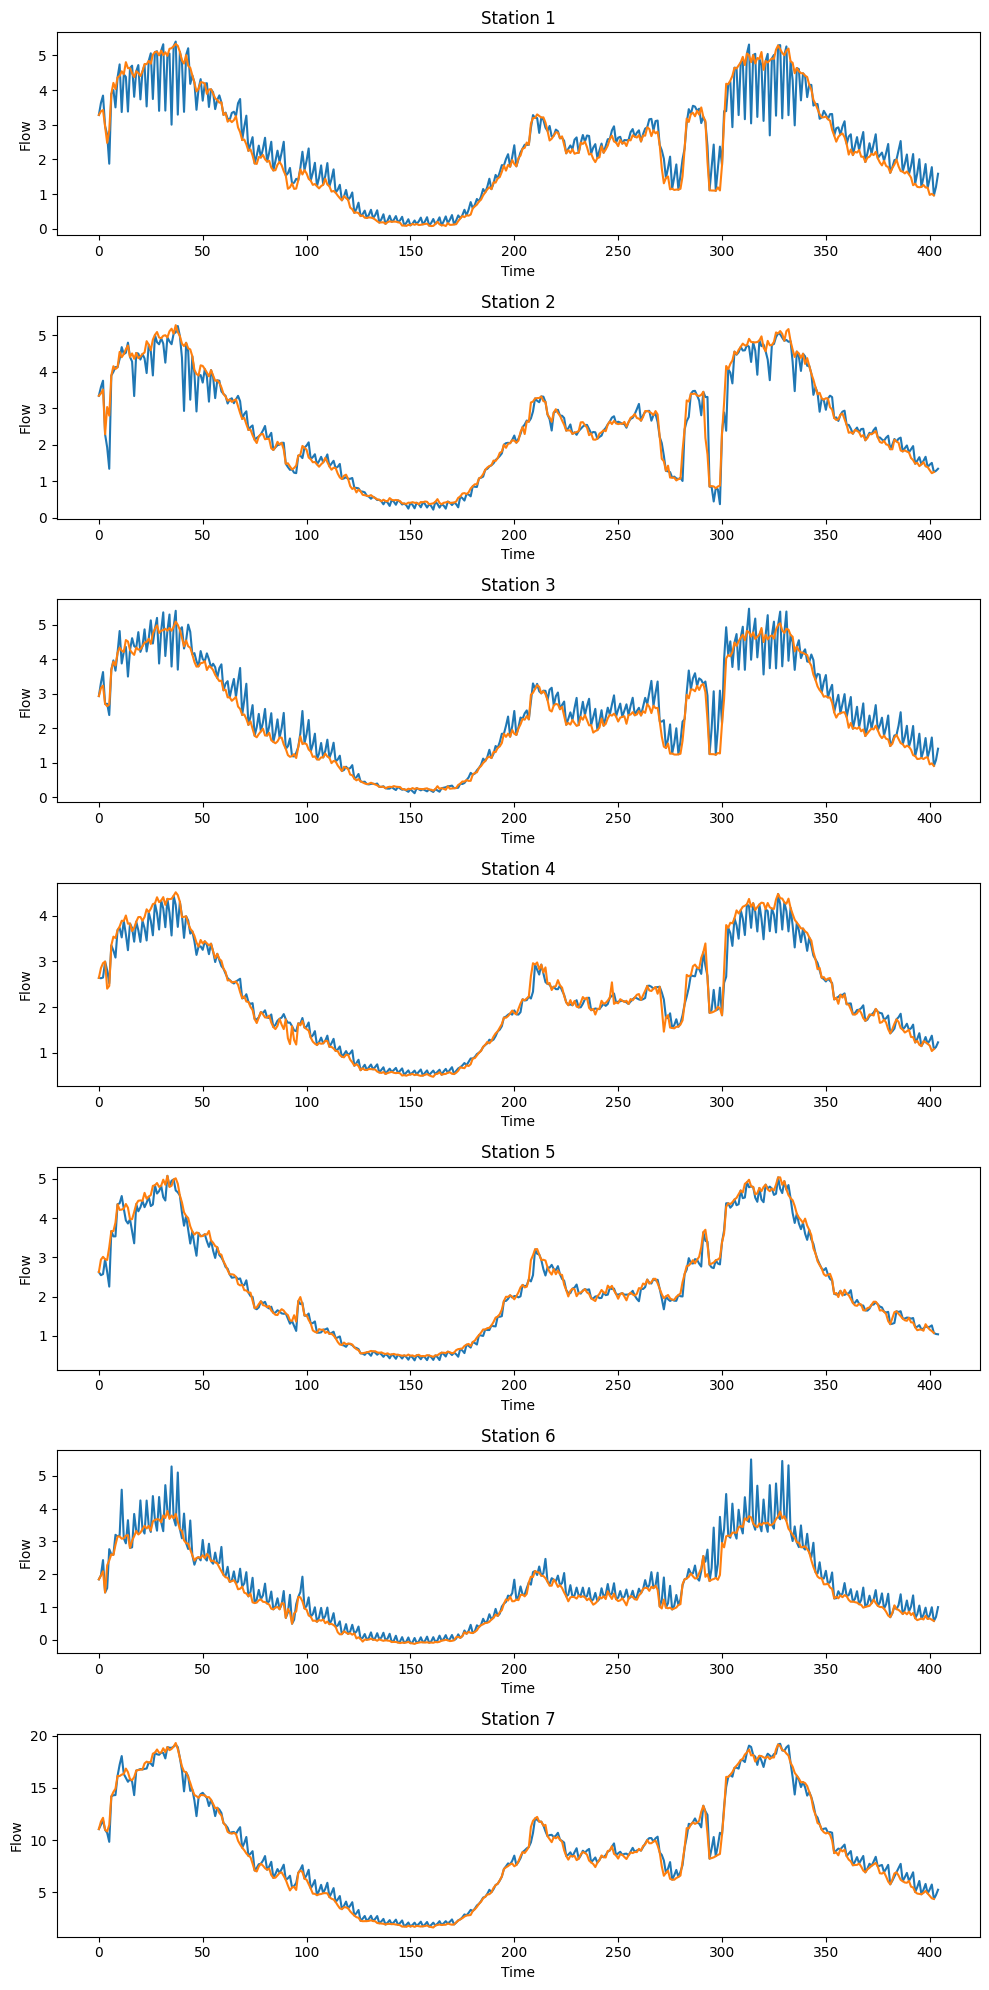

In [54]:
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(10, 20))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(sim_result[:, i])
    axs[i].plot(z[:,i])

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()